In [1]:
import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220320'
}

q = """
select
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
from {db}.feed_actions 
where
    toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21'
    and exp_group in (1,2)
group by exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [3]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


#### t-тест

In [4]:
print(np.round(stats.ttest_ind(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, equal_var=False).pvalue, 4))
print('t-тест показывает, что у нас нет оснований отклонить нулевую гипотезу о равенстве средних, то есть новый алгоритм рекомендаций не привел к статистически значимому увеличению ctr')

0.4781
t-тест показывает, что у нас нет оснований отклонить нулевую гипотезу о равенстве средних, то есть новый алгоритм рекомендаций не привел к статистически значимому увеличению ctr


#### тест Манна-Уитни

In [5]:
print(np.round(stats.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, alternative = 'two-sided').pvalue, 4))
print('однако тест Манна-Уитни указывает на то, что между выборками есть статистически значимое различие')

0.0
однако тест Манна-Уитни указывает на то, что между выборками есть статистически значимое различие


#### t-тест для сглаженного ctr

In [6]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [7]:
global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

group_1 = df[df.exp_group == 1].copy()
group_1['sctr'] = group_1.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

group_2 = df[df.exp_group == 2].copy()
group_2['sctr'] = group_2.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [8]:
print(np.round(stats.ttest_ind(group_1.sctr, group_2.sctr, equal_var=False).pvalue, 4))
print('t-тест показывает, что между выборками есть статистически значимое различие по сглаженному ctr')

0.0224
t-тест показывает, что между выборками есть статистически значимое различие по сглаженному ctr


#### пуассоновский бутстреп

In [9]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

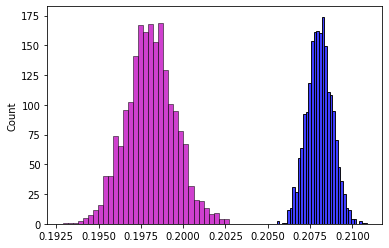

In [10]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()

likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color='b')
sns.histplot(ctr2, color='m')

<AxesSubplot:ylabel='Count'>

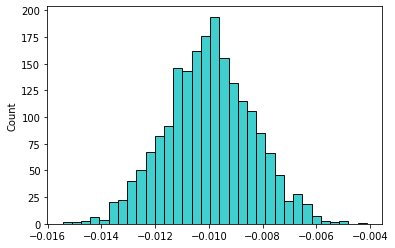

In [11]:
sns.histplot(ctr2 - ctr1, color='c')

In [12]:
print('пуассоновский бутстреп указывает на статистически значимое различие между распределениями ctr, гистограммы не пересекаются')

пуассоновский бутстреп указывает на статистически значимое различие между распределениями ctr, гистограммы не пересекаются


#### бакетное преобразование

In [13]:
qb = """
select
    exp_group, bucket,
    sum(likes) / sum(views) as bucket_ctr
from (
    select
        exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
    from {db}.feed_actions 
    where
        toDate(time) >= '2022-03-15' and toDate(time) <= '2022-03-21'
        and exp_group in (1,2)
    group by exp_group, bucket, user_id
    )
group by exp_group, bucket
"""

dfb = ph.read_clickhouse(qb, connection=connection)

In [14]:
dfb.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


In [15]:
print(f'MW-test: {np.round(stats.mannwhitneyu(dfb[dfb.exp_group == 1].bucket_ctr, dfb[dfb.exp_group == 2].bucket_ctr, alternative="two-sided").pvalue, 4)}')
print(f't-test: {np.round(stats.ttest_ind(dfb[dfb.exp_group == 1].bucket_ctr, dfb[dfb.exp_group == 2].bucket_ctr, equal_var=False).pvalue, 4)}')
print(f'при использовании бакетного преобразования оба теста видят различие между выборками')

MW-test: 0.0
t-test: 0.0
при использовании бакетного преобразования оба теста видят различие между выборками


#### гистограммы ctr

<AxesSubplot:xlabel='ctr', ylabel='Count'>

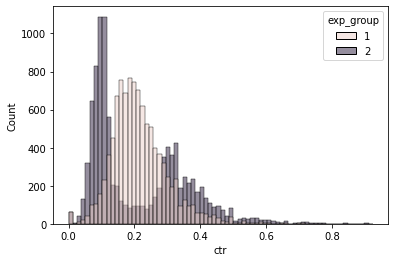

In [16]:
sns.histplot(data=df, x='ctr', hue='exp_group')

In [17]:
np.round(df[df.exp_group == 1].ctr.mean(), 4)

0.2156

In [18]:
np.round(df[df.exp_group == 2].ctr.mean(), 4)

0.2144

#### выводы

Тогда как обычный t-тест указывает на отсутствие статистически значимого различия между двумя группами в плане ctr, все прочие методы фиксируют наличие отличий между двумя выборками.<br><br>
Посмотрев на гисторгаммы ctr и оценив средние значения двух выборок, можно заметить, что распределение для группы с новым алгоритмом рекомендаций имеет иной вид (в частности, бимодальное и скошенность), однако примерно то же среднее значение (из-за чего t-тест не прокрасился).<br><br>Таким образом, можно сделать заключение, что ctr для двух групп все-таки имеет различное распределение. Применение нового алгоритма повышает вовлеченность какой-то подгруппы пользователей, тогда как пользовательский опыт другой группы значительно ухудшается.<br><br>Я бы не рекомендовал внедрение такого алгоритма. Кажется, что повышение ctr одной подгруппы будет достигнуто ценой постепенного оттока другой подгруппы пользователей.